# Programming Assignment 2 - Elastic net regression without libraries

CAP 5625 Computational Foundations of AI - Fall 2021 - Dr. DeGiorgio
<br>Christian Garbin

Instructions to run the code are available in the README.md file.

# Setting up the environment

Import the Python modules we use in the notebook and configure the Jupyter environment.

In [25]:
import copy
import itertools
from typing import Tuple
import numpy as np
import pandas as pd

# Import and set up the graphing environment
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Make plots legible and focus on trends (not specific values)
sns.set_style('white')
sns.set_context('notebook', font_scale=1.5, rc={"lines.linewidth": 2})
sns.despine();

<Figure size 432x288 with 0 Axes>

Import our elastic net regression module and the utilities.

In [26]:
import utils
import elastic_net

# Ancillary code and definitions

Run the automated tests to verify the code works as intended before we start the experiments.

In [27]:
import test
# Set to true to see each test result
test.verbose = False
test.test_all()
print('All tests passed')

All tests passed


Constants used in the experiments.

In [85]:
LAMBDAS_TO_TEST = [1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6]
ALPHAS_TO_TEST = [0.0, 1/5, 2/5, 3/5, 4/5, 1.0]
LR = 0.0001
NUM_FOLDS = 5

Read the dataset and prepare it by encoding categorical columns, standardizing if asked to do so. Note that there is no caching. For a larger dataset we should probably cache it.

Also set constants that depend on the dataset.

In [86]:
FEATURE_NAMES = []

def read_dataset(standardize: bool = True) -> Tuple[np.ndarray, np.ndarray]:
    global FEATURE_NAMES
    
    x, y, FEATURE_NAMES = utils.read_dataset('Credit_N400_p9.csv')

    # Encode the categorical values
    utils.encode_binary_cateogry(x, column=6, one_value='Female')  # gender
    utils.encode_binary_cateogry(x, column=7, one_value='Yes')  # student
    utils.encode_binary_cateogry(x, column=8, one_value='Yes')  # married

    if standardize:
        utils.scale(x)
        utils.center(y)

    return x, y

# Deliverable 1 - effect of alpha on coefficients

> _Illustrate the effect of the tuning parameter on the inferred elastic net regression coefficients by generating six plots (one for each α value) of nine lines (one for each of the p = 9 features), with the y-axis as β̂j, j = 1,2, ... ,9, and the x-axis the corresponding log-scaled tuning parameter value log10(λ) that generated the particular β̂j._

A helper plot function.

In [87]:
def plot_betas(betas: np.ndarray, title: str):
    # Create a DataFrame in the long format
    df = pd.DataFrame(np.squeeze(betas), columns=FEATURE_NAMES,
                      index=LAMBDAS_TO_TEST)
    df = df.stack().reset_index()
    df.columns = ['Lambda', 'Feature', 'Standardized Coefficients']
    
    # Plot it
    fig, ax = plt.subplots(figsize=(12, 6));
    sns.lineplot(ax=ax, y='Standardized Coefficients', x='Lambda',
                 hue='Feature', data=df)
    ax.set_xscale('log')
    ax.set_title(title)
    plt.legend(bbox_to_anchor=(1.04,1), loc='upper left')
    plt.show()

Perform regression with the different alpha and lambda values and plot each alpha (takes several seconds to complete)

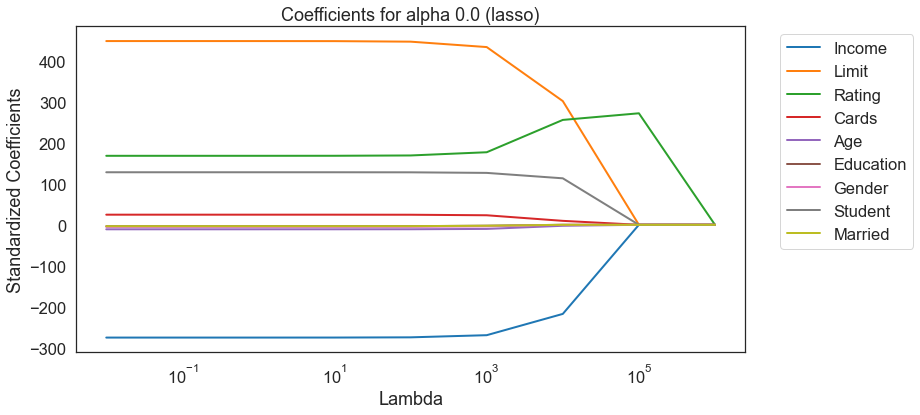

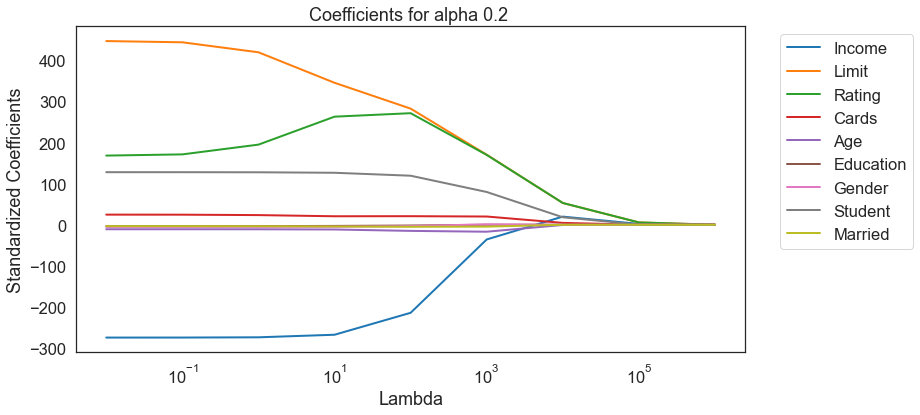

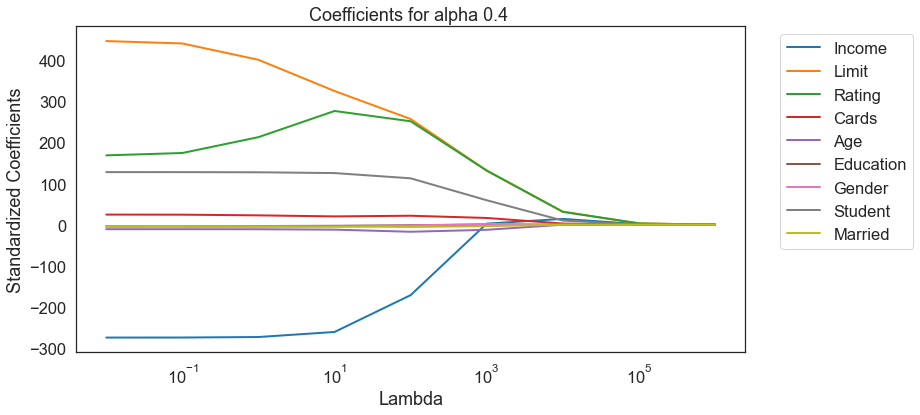

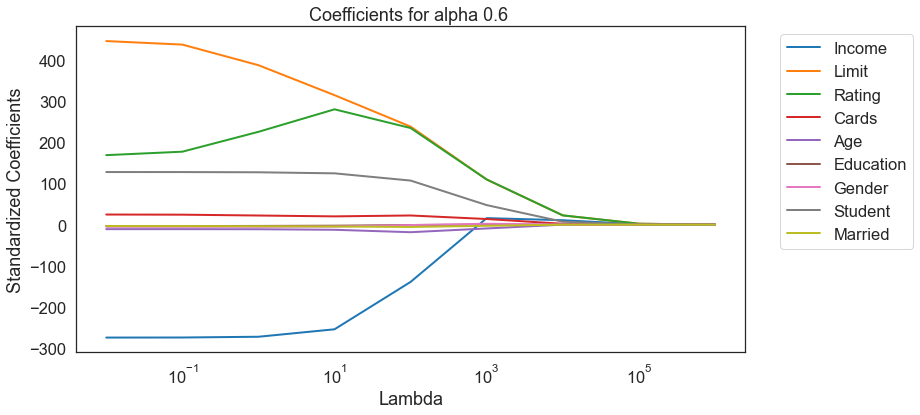

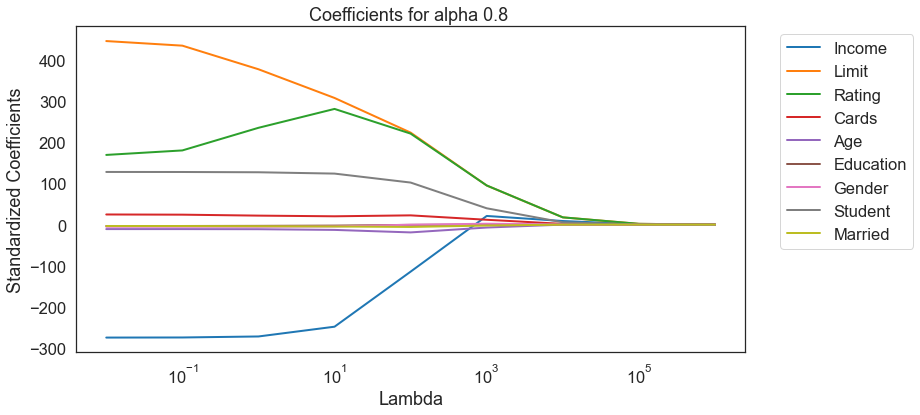

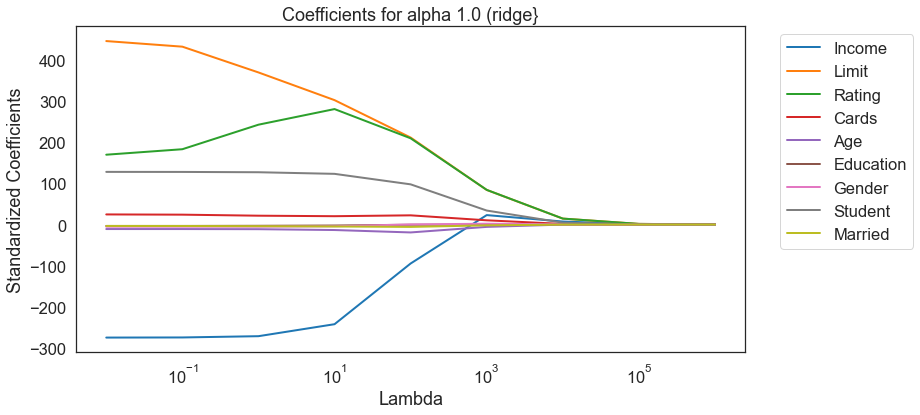

In [88]:
for alpha in ALPHAS_TO_TEST:
    betas = []
    for lmbda in LAMBDAS_TO_TEST:
        x, y = read_dataset()
        b = elastic_net.fit(x, y, lmbda=lmbda, alpha=alpha, iterations=1_000)
        betas.append(b)
    annotation = '(lasso)' if alpha == 0 else '(ridge}' if alpha == 1.0 else ''
    plot_betas(betas, f'Coefficients for alpha {alpha} {annotation}')

# Deliverable 2 - effect of lambda on MSE (with cross validation)

> _Illustrate the effect of the tuning parameters on the cross validation error by generating a plot of six lines (one for each α value) with the yaxis as CV(5) error, and the x-axis the corresponding log-scaled tuning parameter value log10(λ) that generated the particular CV(5) error._

Perform regression with the different lambda values and cross validation (takes several seconds to complete).

In [89]:
mse = []
for (alpha, lmbda) in itertools.product(ALPHAS_TO_TEST, LAMBDAS_TO_TEST):
    x, y = read_dataset(standardize=False)
    fold_mse = np.zeros(NUM_FOLDS)
    for fold in range(1, NUM_FOLDS+1, 1):
        x_train, x_val, y_train, y_val = utils.split_fold(x, y,
                                                          num_folds=NUM_FOLDS,
                                                          fold=fold)
        utils.scale_val(x_train, x_val)
        utils.center_val(y_train, y_val)

        model = elastic_net.fit(x_train, y_train, lmbda=lmbda, alpha=alpha, iterations=1_000)
        predictions = elastic_net.predict(x_val, model)
        fold_mse[fold-1] = utils.mse(y_val, predictions)
    mse.append([alpha, lmbda, fold_mse.mean()])

Plot the results.

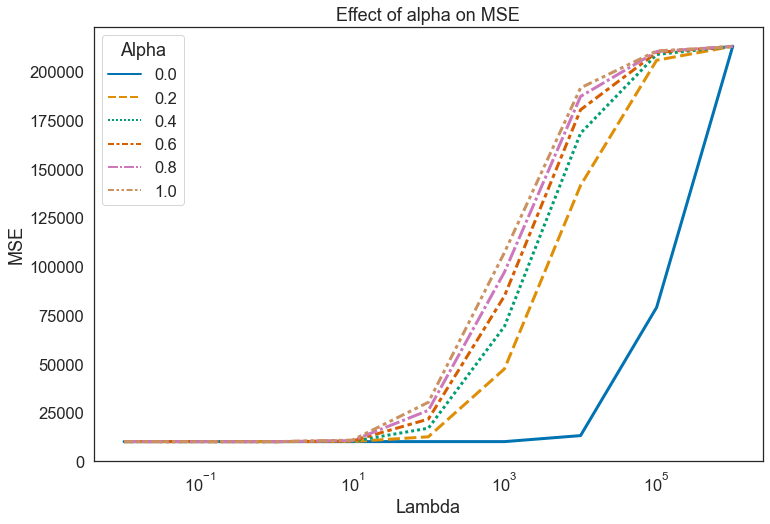

In [137]:
def plot_mse(mse: pd.DataFrame, title: str):
    # Plot it
    fig, ax = plt.subplots(figsize=(12, 8));
    # Use dashes and a contrasting palette to make it easier to tell them apart
    sns.lineplot(ax=ax, y='MSE', x='Lambda', hue='Alpha', data=mse,
                 style='Alpha', palette='colorblind', linewidth=3)
    ax.set_xscale('log')
    ax.set_title(title)

mse_df = pd.DataFrame(mse, columns=['Alpha', 'Lambda', 'MSE'])
plot_mse(mse_df, 'Effect of alpha on MSE')

# Deliverable 3 - the lambda with the smallest MSE

> _Indicate the value of 𝜆 that generated the smallest CV(5) error._

In [10]:
smallest_sme_index = mse.argmin()
smallest_sme_lambda = LAMBDAS_TO_TEST[smallest_sme_index]
print(f'The lambda with the smallest MSE is {smallest_sme_lambda}')

The lambda with the smallest SME is 0.01


# Deliverable 4 - model parameters for the lambda with the smallest MSE

> _Given the optimal 𝜆, retrain your model on the entire dataset of N=9 observations and provide the estimates of the p=9 best-fit model parameters._

Train a model with the lambda that resulted in the smallest MSE.

In [11]:
x, y = read_dataset()
betas4 = elastic_net.fit(x, y, lr=LR, lmbda=smallest_sme_lambda, iterations=100_000)

Show the coefficients for this model.

In [12]:
for feature, beta in zip(FEATURE_NAMES, betas4.flatten()):
    print(f'{feature:>10}: {beta:7.2f}')

    Income: -274.65
     Limit:  419.65
    Rating:  195.85
     Cards:   23.45
       Age:  -10.96
 Education:   -3.35
    Gender:   -5.20
   Student:  127.78
   Married:   -3.60


# Deliverable 6 - repeat with a machine learning library

> _Implement the assignment using statistical or machine learning libraries in a language of your choice. Compare the results with those obtained above, and provide a discussion as to why you believe your results are different if you found them to be different._

In this section we repeat the experiments above using scikit-learn. It uses the `sag` solver because it is the closest to the one implemented in our code (a gradient descent algorithm).

In [13]:
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import pipeline
from sklearn import metrics

## Deliverable 6.1 - effect of lambda on coefficients

In [14]:
betas_sk = []
for lmbda in LAMBDAS_TO_TEST:
    x, y = read_dataset(standardize=False)
    model_sk = pipeline.make_pipeline(preprocessing.StandardScaler(),
                                      linear_model.ElasticNet(alpha=lmbda))
    model_sk.fit(x, y)
    coef_sk = model_sk.named_steps['ridge'].coef_
    betas_sk.append(coef_sk)

Plots the results.

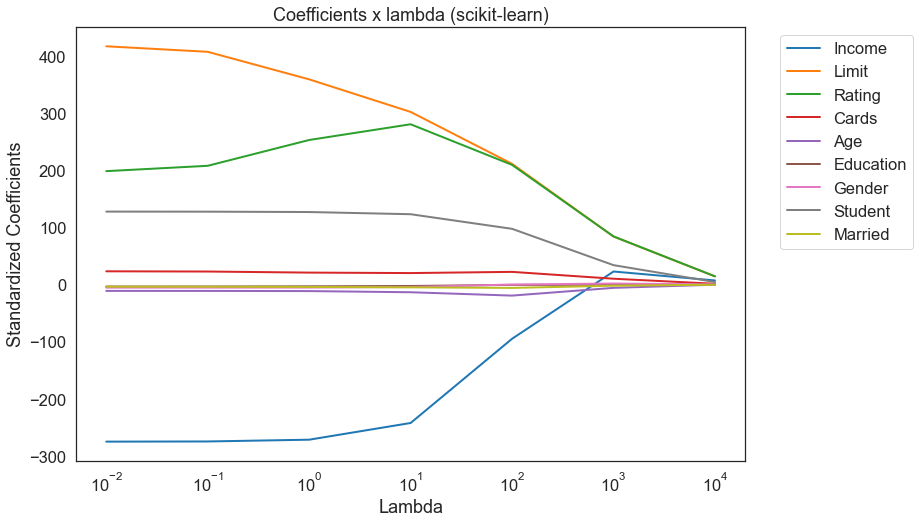

In [15]:
plot_betas(betas_sk, 'Coefficients x lambda (scikit-learn)')

## Deliverable 6.2 - effect of lambda on MSE (with cross validation)

Fit one model for each value of lambda. Ask scikit-learn to store the cross-validation results (`store_cv_values`) so we can calculate the mean MSE for each lambda.

In [16]:
x, y = read_dataset(standardize=False)
p = pipeline.make_pipeline(preprocessing.StandardScaler(),
                           linear_model.ElasticNetCV(alphas=LAMBDAS_TO_TEST,
                           store_cv_values=True))
p.fit(x, y)
model_sk = p.named_steps['ridgecv']

# Mean SME for each fold
mse_sk = model_sk.cv_values_.mean(axis=0)

Plot the results.

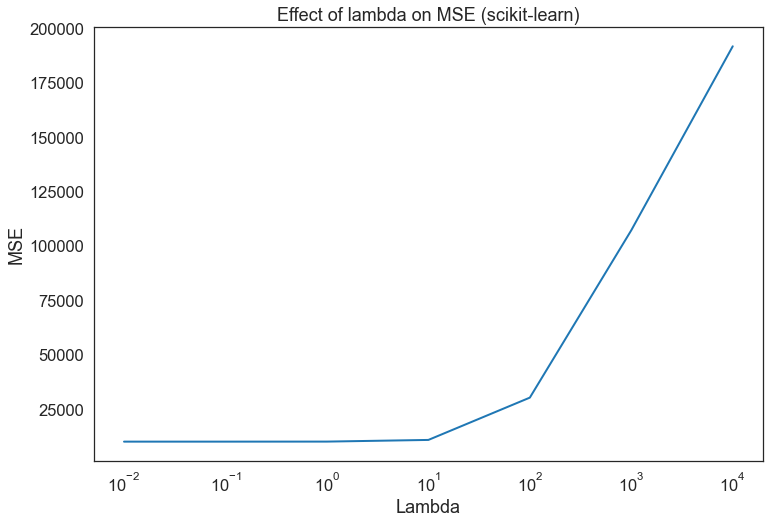

In [17]:
plot_mse(mse_sk, 'Effect of lambda on MSE (scikit-learn)')

## Deliverable 6.3 - the lambda with the smallest MSE

In [18]:
print(f'The lambda with the smallest MSE is {model_sk.alpha_}')

The lambda with the smallest SME is 0.1


## Deliverable 6.4 - model parameters for the lambda with the smallest MSE

In [19]:
x, y = read_dataset(standardize=False)
p = pipeline.make_pipeline(preprocessing.StandardScaler(),
                           linear_model.Ridge(alpha=model_sk.alpha_))
p.fit(x, y)
coef_sk = p.named_steps['ridge'].coef_
for feature, beta in zip(FEATURE_NAMES, coef_sk.flatten()):
    print(f'{feature:>10}: {beta:7.2f}')

    Income: -274.30
     Limit:  430.61
    Rating:  184.52
     Cards:   23.94
       Age:  -10.98
 Education:   -3.40
    Gender:   -5.19
   Student:  127.81
   Married:   -3.52


## Discussion of differences

The result or our code were close to the ones from scikit-learn. For all practical purposes, we can say that the results are the same for both implementations.

The major differences are in the implementation details. In general, the scikit-learn implmentation is more efficient. More specifically:

- It dynamically calculates the learning rate. In our code we had to experiment with several learningn rates to find an optimal one.
- It converges orders of magnitude more quickly. Besides choosing a better learning rate, [the core of the optimizer is implemented in Cython](https://github.com/scikit-learn/scikit-learn/blob/main/sklearn/linear_model/_sag_fast.pyx.tp)